# Time series Prediction using LSTM (univariate)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns

np.random.seed(7)

In [4]:
path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\geopy\france_cleaned"

region = "Touraine.csv"
region_name = region.split('.')[0]
df = pd.read_csv(path+'\\'+region)

In [5]:
unlabelled_dataset = pd.read_excel('to_predict.xlsx') # unlabelled dataset to predict

temp_df = df[df['PARAMETER'] == 'T2M'] # separate the temperature from the humidity
temp_df = temp_df.drop('ANN', axis = 1)


temp_df = temp_df.rename(columns = {'JAN':1, 'FEB':2,'MAR':3, 'APR':4, 'MAY':5,'JUN':6,
                         'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}) # convert months to numerice
temp_df = temp_df.drop(['PARAMETER','LAT','LON'], axis = 1) 

temp_df.set_index('YEAR', inplace = True)
df = pd.concat([temp_df.stack()], axis=1)
df.reset_index(inplace = True)

df.rename(columns = {'level_1':'month',0:'avg_temp'}, inplace = True)

df['date'] = df[['YEAR','month']].astype(str).apply('-'.join, axis=1)

df['date'] = pd.to_datetime(df['date'])
df.set_axis(df['date'], inplace=True)

df = df.drop(['YEAR','month','date'], axis = 1)
print(df.shape)

(468, 1)


In [6]:
df.tail(12)

,avg_temp
date,
2019-01-01,-0.69
2019-02-01,0.83
2019-03-01,3.61
2019-04-01,12.64
2019-05-01,17.68
2019-06-01,21.66
2019-07-01,25.19
2019-08-01,24.03
2019-09-01,21.73


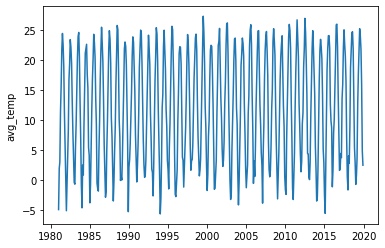

In [7]:
plt.plot(df)
plt.ylabel('avg_temp')
plt.show()

In [8]:
# data splitting
scaler = MinMaxScaler()

data = scaler.fit_transform(df)
train_size = int(len(data) * 0.80)
valid_size = len(data) - train_size
train, valid = data[0:train_size,:], data[train_size:len(data),:] 

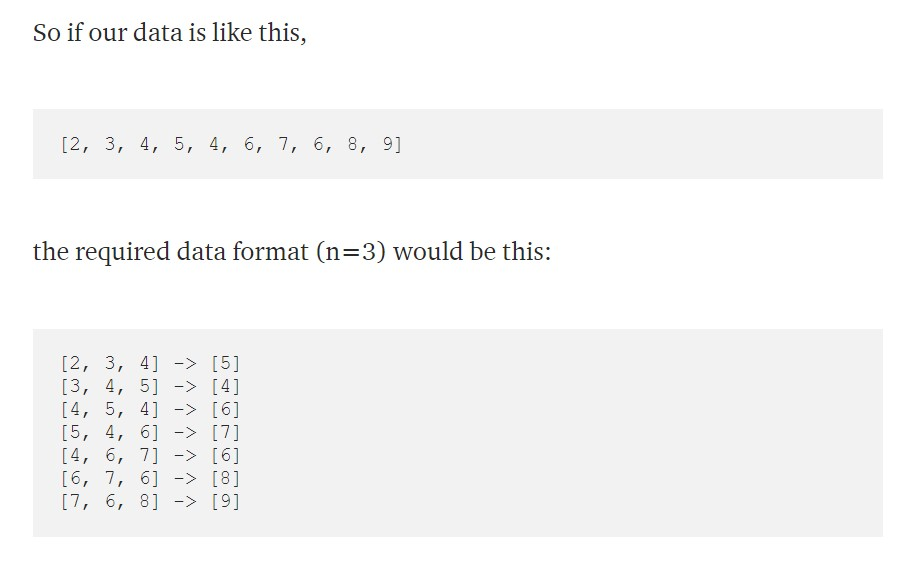

In [9]:
### Time series generator arranges the data for time series prediction 
from IPython.display import Image
Image(filename = "img/time series generator.jpg")

In [10]:
from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 12

train_generator = TimeseriesGenerator(train, train, length=look_back,batch_size=5, shuffle = False)     
valid_generator = TimeseriesGenerator(valid, valid, length=look_back, batch_size=1, shuffle = False)

In [11]:
# print each sample
#for i in range(len(train_generator)):
#    x, y = train_generator[i]
#    print('%s => %s' % (x, y))

In [12]:
#for i in range(len(test_generator)):
#    x, y = test_generator[i]
#    print('%s => %s' % (x, y))

In [13]:
#n_features = X_train.shape[1]
BATCH_SIZE = 5
EPOCHS = 30
DROPOUT_RATE= 0.01 # 0.01
LSTM_UNIT_SIZE = 5 #5

model = Sequential()
model.add(LSTM(LSTM_UNIT_SIZE, activation = 'relu', input_shape=(look_back, train.shape[1])))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# model compilation 
#model.compile(optimizer = 'adam', loss = 'mse')
# fit the model 
saved_model_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\france_saved_models\\"

# patience number of epochs with no improvement training will be stopped. 
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

# good practice to name the model based on the region_name
mc = ModelCheckpoint(saved_model_path+f'{region_name}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data = valid_generator, callbacks = [early_stopping_callback, mc]) #,mc # callbacks = [early_stopping_callback, mc]

Epoch 1/30
73/73 [==============================] - 1s 14ms/step - loss: 0.1824 - val_loss: 0.0349

Epoch 00001: val_loss improved from inf to 0.03494, saving model to C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\france_saved_models\\Touraine.h5
Epoch 2/30
73/73 [==============================] - 1s 9ms/step - loss: 0.0790 - val_loss: 0.0944

Epoch 00002: val_loss did not improve from 0.03494
Epoch 3/30
73/73 [==============================] - 1s 8ms/step - loss: 0.0573 - val_loss: 0.0640

Epoch 00003: val_loss did not improve from 0.03494
Epoch 4/30
73/73 [==============================] - 1s 7ms/step - loss: 0.0446 - val_loss: 0.0529

Epoch 00004: val_loss did not improve from 0.03494
Epoch 5/30
73/73 [==============================] - 1s 8ms/step - loss: 0.0283 - val_loss: 0.0260

Epoch 00005: val_loss improved from 0.03494 to 0.02600, saving model to C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESI

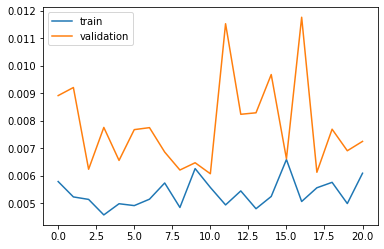

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation') # validation
plt.legend()
plt.show()

In [50]:
# load the best model name 
saved_model = load_model(saved_model_path+f'{region_name}.h5')
print('Model name: ',region_name+'.h5')

Model name:  Tavel.h5


In [51]:
# evaluation on the validation
saved_model.evaluate_generator(valid_generator)

0.0060811215080320835

In [52]:
# get the prediction on the training data 
# get the prediction on the testing (validation) data 

train_prediction = saved_model.predict_generator(train_generator)
print('Shape of the training prediction: ', train_prediction.shape)
valid_prediction = saved_model.predict_generator(valid_generator)
print('Shape of the test/validation prediction: ', valid_prediction.shape)

Shape of the training prediction:  (362, 1)
Shape of the test/validation prediction:  (82, 1)


In [53]:
# invert the predictions and scale back to real temperature ranges. 

train_prediction = scaler.inverse_transform(train_prediction)
valid_prediction = scaler.inverse_transform(valid_prediction)

In [54]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [55]:
y_train_gen = get_y_from_generator(train_generator)
y_valid_gen = get_y_from_generator(valid_generator)

y_train_orig = scaler.inverse_transform(y_train_gen) # inverse the prediction from the generator to original form
y_valid_orig = scaler.inverse_transform(y_valid_gen) # inverse the y valid from generator

(362, 1)
(82, 1)


In [56]:
# calculate root mean squared error
import math


trainScore = math.sqrt(mean_squared_error(y_train_orig[:,0], train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_valid_orig[:, 0], valid_prediction[:,0]))
print('valid Score: %.2f RMSE' % (testScore))

Train Score: 1.91 RMSE
valid Score: 1.89 RMSE


In [57]:
# training 

original_y_train =  pd.DataFrame(y_train_orig).rename(columns = {0:'y'}) 
prediction_train = pd.DataFrame(train_prediction).rename(columns = {0:'y_hat'}) 
df_residual_train = pd.concat([original_y_train,prediction_train], axis = 1)
df_residual_train['residual'] = df_residual_train['y'] - df_residual_train['y_hat']

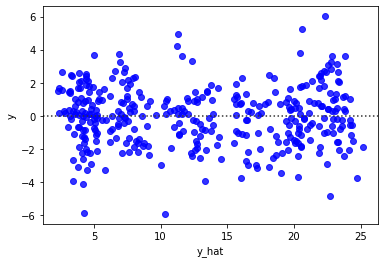

In [58]:
plot_train = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\plot train residuals\\"

sns_plot = sns.residplot(x ='y_hat', y = 'y', data = df_residual_train, color = 'blue')
sns_plot.figure.savefig(plot_train+f'{region_name} valid residual.png')

### this observation is only on the alsace dataframe

Observation: there tend to be clusters of temperatures around 0-7, 8-13, and 13-22 (by eye only).  Bigger residuals on colder temperatures ~-2 - 2. 

In [59]:
#residual error = expected - forecast

#validation
original_y_valid =  pd.DataFrame(y_valid_orig).rename(columns = {0:'y'}) 
prediction_valid = pd.DataFrame(valid_prediction).rename(columns = {0:'y_hat'}) 
df_residual = pd.concat([original_y_valid,prediction_valid], axis = 1)

df_residual['residual'] = df_residual['y'] - df_residual['y_hat']

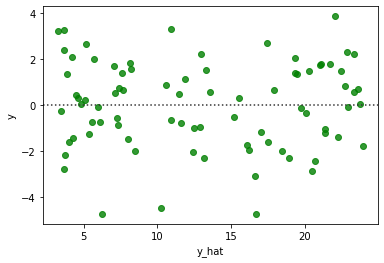

In [60]:
plot_valid = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\plot valid residuals\\"

sns_plot = sns.residplot(x ='y_hat', y = 'y', data = df_residual, color = 'green')
sns_plot.figure.savefig(plot_valid+f'{region_name} valid residual.png')

Residual interpretation on validation: 
some residuals are positive and some are negative. The horizontal line is the least square regression line. When residuals are positive this means datapoints are above regression line and if negative then datapoint is below the regression line. 

### this observation is only on the alsace dataframe
Interpretation: <br>
Higher residuals on lower temperatures. 


In [61]:
y_train_orig.shape

(362, 1)

In [62]:
train_prediction.shape

(362, 1)

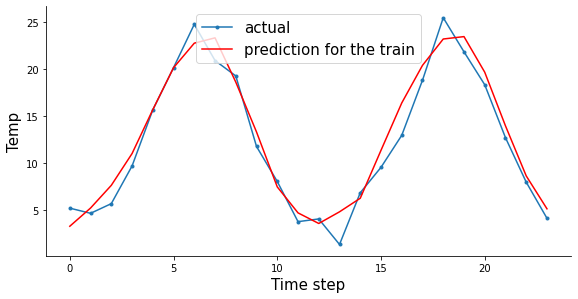

In [63]:
import seaborn as sns

plot_train_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\plot of training\\"

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_train_orig[:24], marker='.', label="actual") 
plt.plot(aa, train_prediction[:24], 'r', label="prediction for the train")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig(plot_train_path+f'{region_name} train.png')
plt.show();




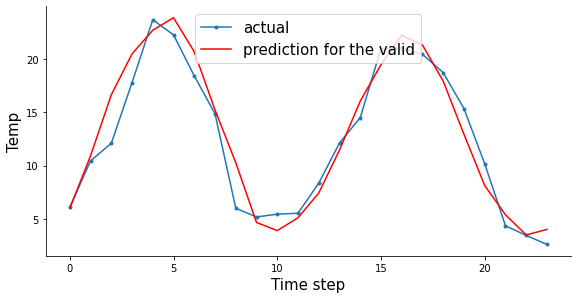

In [64]:
import seaborn as sns

plot_valid_path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\plot of valid\\"

aa=[x for x in range(24)]
plt.figure(figsize=(8,4))
plt.plot(aa, y_valid_orig[:24], marker='.', label="actual") 
plt.plot(aa, valid_prediction[:24], 'r', label="prediction for the valid")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Temp', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig(plot_valid_path+f'{region_name} valid.png')
plt.show();

In [65]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_prediction)+look_back] = train_prediction
trainPredictPlot = trainPredictPlot + df


# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_prediction)+ (look_back * 2):] = valid_prediction
testPredictPlot = testPredictPlot + df

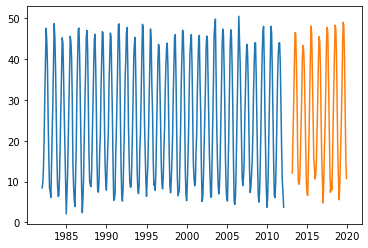

In [66]:
#plt.plot(df)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Predicting the future dates 


The idea here is to generate a prediction for one future step using the last 12 steps. 
Add the new prediction to the array, remove the first entry from the same array and predict the next step with an updated array of 12 steps. 

In [67]:
valid[-12:] #

array([[0.13346815],
       [0.2851365 ],
       [0.36130772],
       [0.42871587],
       [0.53758005],
       [0.81429053],
       [0.93933266],
       [0.89821368],
       [0.74081564],
       [0.57802494],
       [0.30131446],
       [0.29389956]])

In [68]:
# prediction for year 2030

pred_list = []

batch = valid[-look_back:].reshape((1, look_back, valid.shape[1]))  # 1,12,1

for i in range(24):   # 2020 - 2030
    pred_list.append(saved_model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [69]:
predictions = scaler.inverse_transform(pred_list)
print(predictions[-12:]) # year 2021

[[ 3.44682377]
 [ 4.71746093]
 [ 7.73762891]
 [12.38252548]
 [17.77316631]
 [21.81409861]
 [23.72073189]
 [22.73339343]
 [18.33533634]
 [11.89203684]
 [ 6.54238914]
 [ 4.02752603]]


In [70]:
pred_df = pd.DataFrame(predictions)
unlabelled_df = pd.read_excel('to_predict.xlsx')
final_prediction = pd.concat([unlabelled_df,pred_df], axis = 1).rename(columns = {0:'predicted_temp'})
path = r"C:\Users\rezan\Documents\Master in Applied Data Science\2nd Year\MASTER THESIS\GIT THESIS\FrancePredictions\\"
final_prediction.to_excel(path+f' {region_name}.xlsx') # saving the final prediction to the path 

In [71]:
print(region_name)
final_prediction

Tavel


,YEAR,month,month_sin,month_cos,predicted_temp
0,2020,1,0.000000e+00,1.000000e+00,4.031883
1,2020,2,5.000000e-01,8.660254e-01,4.752157
2,2020,3,8.660254e-01,5.000000e-01,7.369524
3,2020,4,1.000000e+00,6.123234e-17,11.623252
4,2020,5,8.660254e-01,-5.000000e-01,16.903732
5,2020,6,5.000000e-01,-8.660254e-01,21.303863
6,2020,7,1.224647e-16,-1.000000e+00,23.451730
7,2020,8,-5.000000e-01,-8.660254e-01,23.005987
8,2020,9,-8.660254e-01,-5.000000e-01,19.011155
9,2020,10,-1.000000e+00,-1.836970e-16,12.525908
